# Connection between Ising and MWC model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import numba
from numba import jit
import scipy.optimize as spopt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
import animatplot as amp

In [2]:
@numba.jit(nopython=True)

# this function determines the coupling energy based on the location of the spin
def rates_2d_numba(J,H,state,omega0=1):
    # shift the lattices and remove some neighbours for the edges
    left = np.empty(state.shape)
    right = np.empty(state.shape)
    top = np.empty(state.shape)
    bottom = np.empty(state.shape)
    
    # roll the states (in the dumb numba way)
    for i in range(state.shape[0]):
        left[i,:] = np.roll(state[i,:],1)
        right[i,:] = np.roll(state[i,:],-1)
        top[:,i] = np.roll(state[:,i],1)
        bottom[:,i] = np.roll(state[:,i],-1)
    
    # remove edges
    left[:,0] = 0.
    right[:,-1] = 0.
    top[0,:] = 0.
    bottom[-1,:] = 0.
    
    # compute coupling summation for each spin
    coupling = J*state*(left + right + top + bottom)
    
    # energy difference associated to external field
    field = H*state
    
    # return the rates
    return omega0*np.exp(-(coupling + field))

@numba.jit(nopython=True)

# function that implements dynamic Ising model using Gillespie's algorithm
def ising_2d_lig(n_sims,L,J,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900):
    # initialise
    state = np.random.choice(np.array([-1.,1.]),size=(L,L))

    # array to store all results
    all_states = np.zeros((n_sims,L,L))
    all_states[0,:,:] = state

    # store all waiting times
    waiting_times = np.zeros(n_sims)
    
    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    
    # perform Gillespie's algorithm
    for k in range(1,n_sims):
        # change concentration after some steps
        if k >= step_change:
            c = cnew
        else:
            c = cbase
        
        # define the external field 
        H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka)))
        
        # obtain rates of flipping
        rates = rates_2d_numba(J,H,state)
        Omega = np.sum(rates)

        # sample time until next event
        u1 = np.random.uniform(0,1)
        dt = -np.log(u1)/Omega
        waiting_times[k] = dt
        
        # select which spin i is flipped
        p = np.random.uniform(0,1)*Omega
        mask = p < np.cumsum(rates)
        i = np.where(mask == True)[0][0]
        
        # convert to coordinates in the lattice
        m,l = np.divmod(i,L)

        # flip the selected spin and save it
        state[m,l] *= -1
        all_states[k,:,:] = state
        
    return all_states, waiting_times

In [3]:
@numba.jit(nopython=True)

# function that implements dynamic Ising model using Gillespie's algorithm
def ensemble_averaged_ising(n_samples,n_steps,tf,L,J,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900):

    # array to store all results
    all_states = np.zeros((n_samples,n_steps,L,L),dtype='float64')
    
    # regular time steps
    t_grid = np.linspace(0,tf,n_steps)
    
    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    
    ########################
    ### Actual algorithm ###
    ########################
    
    # loop over n_samples realisations of the algorithm
    for sample in range(n_samples):
        # initialise each realisation
        dt = 0
        time = 0
        
        # initialise
        state = np.random.choice(np.array([-1.,1.]),size=(L,L))
        
        # loop over all time steps
        for step in range(n_steps):
            # change concentration after some steps
            if step >= step_change:
                c = cnew
            else:
                c = cbase
                            
            # define the external field
            H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka)))
            
            # ensure initialisation; not necessary after initial round
            if time == 0:
                # obtain rates of flipping
                rates = rates_2d_numba(J,H,state)
                Omega = np.sum(rates)
                
                # select which spin i is flipped
                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(rates)
                i = np.where(mask == True)[0][0]

                # convert to coordinates in the lattice
                m,l = np.divmod(i,L)

                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
              
            # keep updating until we reach the end of this regular time step
            while time < t_grid[step]:
                # flip the spin
                state[m,l] *= -1
                
                # obtain rates of flipping
                rates = rates_2d_numba(J,H,state)
                Omega = np.sum(rates)
                
                # select which spin i is flipped
                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(rates)
                i = np.where(mask == True)[0][0]

                # convert to coordinates in the lattice
                m,l = np.divmod(i,L)

                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
            # save the last state before passing the boundary
            all_states[sample,step,:,:] = state
            
    #################
    ### Averaging ###
    #################
    
    # array to store ensemble average for each spin
    ensemble_av = np.zeros((n_steps,L,L),dtype='float64')
    
    # averaging (the weird numba way)
    for step in range(n_steps):
        for spin1 in range(L):
            for spin2 in range(L):
                ensemble_av[step,spin1,spin2] = np.mean(all_states[:,step,spin1,spin2])
        
    return all_states, ensemble_av, t_grid

In [21]:
@numba.jit(nopython=True)
def dose_response_curve(n_samples,n_steps,tf,L_arr,J_arr,cnew_arr):
    # set when the concentration is changed
    step_change = 1000

    # store results
    all_responses = np.zeros((J_arr.size,cnew_arr.size,L_arr.size),dtype='float32')
    all_var = np.zeros_like(all_responses,dtype='float32')

    # perform simulation for various L, J and cnew
    for k,L in enumerate(L_arr):
        # update number of samples
        n_samples_L = n_samples//L
        #loop through various coupling strengths
        for i,J in enumerate(J_arr):
            # loop for various new concentrations
            for j, c_new in enumerate(cnew_arr):
                # obtain results
                all_states, ensemble_av, _ = ensemble_averaged_ising(n_samples_L,n_steps,tf,L,J,
                                                                          step_change=step_change,cnew=c_new)
                
                # extract ensemble variance on the activity; note the prefactor!
                ensemble_var = np.zeros((n_steps,L,L),dtype='float32')
                for step in range(n_steps):
                    for spin1 in range(L):
                        for spin2 in range(L):
                            ensemble_var[step,spin1,spin2] = 0.25*np.var(all_states[:,step,spin1,spin2])

                # extract activity, weird numba way
                av_spin = np.sum(np.sum(ensemble_av,axis=-1),axis=-1)/L**2
                activity = 0.5*(av_spin + 1)

                # set baseline and extract new equilibrium
                baseline = np.mean(activity[500:step_change-1]) # remove transient
                new_act = np.mean(activity[-1000:])
                
                # save response
                all_responses[i,j,k] = new_act - baseline
                
                # calculate error in the response, assuming a_pre and a_post have uncorrelated errors
                ens_var_baseline = np.mean(ensemble_var[500:step_change-1])/ensemble_var[500:step_change-1].size
                ens_var_new = np.mean(ensemble_var[-1000:])/ensemble_var[-1000:].size
                
                var_baseline = np.var(activity[500:step_change-1])
                var_new = np.var(activity[-1000:])
                
                # save errors
                all_var[i,j,k] = ens_var_baseline + ens_var_new + var_baseline + var_new

        print('Done for L = ', L)
            
    return all_responses, all_var

# define Hill function
def hill_func_max(conc,delta_a_max,nH):
    return delta_a_max*(conc**nH/(100**nH + conc**nH) - 0.5) 

# function to compute theoretical drc
def theoretical_drc(cnew_arr,N,ampl):
    # fix some parameters
    c0 = 100
    delta_f = -2
    Ki = 18
    Ka = 2900
    
    # adequately set initial methylation
    mbase = N/2.
    m0 = mbase - (N/delta_f)*np.log((1+100/18)/(1+100/2900))
    
    # calculate free-energy difference
    f0 = N*np.log((1 + c0/Ki)/(1 + c0/Ka)) + delta_f*(m0 - mbase)
    fc = N*np.log((1 + cnew_arr/Ki)/(1 + cnew_arr/Ka)) + delta_f*(m0 - mbase)
    
    # calculate average activities
    a_pre = 1/(1 + np.exp(f0))
    a_post = 1/(1 + np.exp(fc))
    
    # return response
    return ampl*(a_post-a_pre)

In [88]:
# make a meshgrid for plotting
J_arr = np.linspace(0,0.6,6)
cnew_arr = np.logspace(-1,5,15)
J_plot, c_plot = np.meshgrid(J_arr,cnew_arr)

# parameters
n_samples = 2000
n_steps = 4000
tf = 2*10**3
L_arr = np.arange(2,8,1)

# array to store results
parm_arr = np.zeros((2,J_arr.size,L_arr.size),dtype='float32')
var_arr = np.zeros_like(parm_arr)

# extract dose-response curves
all_responses, all_var = dose_response_curve(n_samples,n_steps,tf,L_arr,J_arr,cnew_arr)

# extract N for various L and J
for j,J in enumerate(J_arr):
    for l,L in enumerate(L_arr):
        # perform fitting
        popt, pcov = curve_fit(theoretical_drc,cnew_arr,all_responses[j,:,l],
                               maxfev=5000,sigma=np.sqrt(all_var[j,:,l]))
        
        # store results
        parm_arr[:,j,l] = popt
        var_arr[:,j,l] = [pcov[i,i] for i in range(2)]

Done for L =  2
Done for L =  3
Done for L =  4
Done for L =  5
Done for L =  6
Done for L =  7


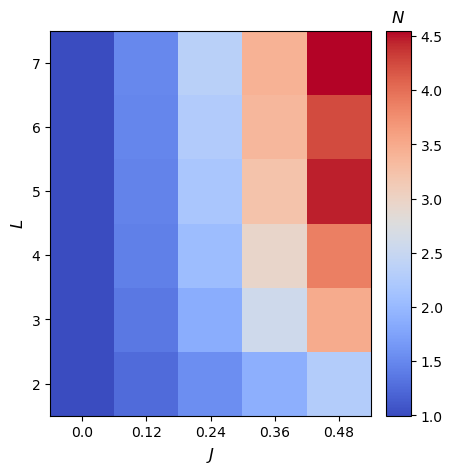

In [93]:
# show results
fig, ax = plt.subplots(1,1,figsize=(5,5))

im = ax.imshow(parm_arr[0,:-1,:].T,cmap=plt.cm.coolwarm)
ax.set_xticks(range(len(J_arr[:-1])), J_arr[:-1])
ax.set_yticks(range(len(L_arr)), L_arr)
ax.invert_yaxis()
ax.set_xlabel(f'$J$',size=12)
ax.set_ylabel(f'$L$',size=12)

# formatting the colorbar
cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.05,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.set_title(r'$N_{eff}$',size=12)

plt.show()

In [95]:
def eff_hill_mwc(N,c0=100,Ki=18,Ka=2900):
    return N*c0*(Ki-Ka)/((Ki+c0)*(Ka+c0))

N_arr = parm_arr[0,:,:]

eff_hill_mwc(N_arr)

array([[ -0.81438762,  -0.81527595,  -0.81205288,  -0.8152899 ,
         -0.81394341,  -0.8126024 ],
       [ -1.02377313,  -1.11067602,  -1.16425503,  -1.19529908,
         -1.21213665,  -1.22960779],
       [ -1.27445569,  -1.51591437,  -1.6791898 ,  -1.78010664,
         -1.84560399,  -1.91199241],
       [ -1.53829061,  -2.1084006 ,  -2.40132804,  -2.62934675,
         -2.74145056,  -2.7861679 ],
       [ -1.85279573,  -2.83798835,  -3.15043856,  -3.62559251,
         -3.44757945,  -3.70297599],
       [ -2.15989989,  -3.46108545,  -4.23947881,  -5.35356532,
        -23.69201412,  -3.99960134]])

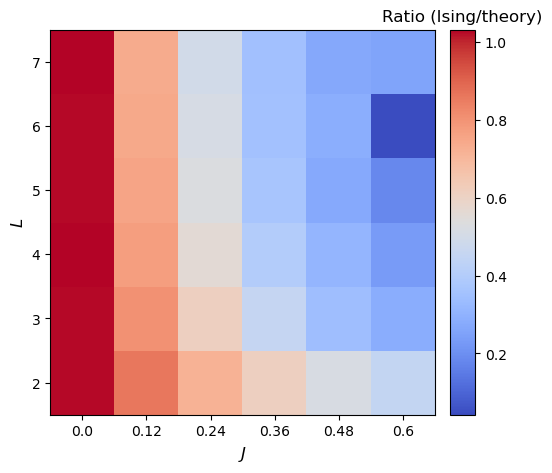

[[-0.83679656 -0.83553578 -0.83800164 -0.83510205 -0.83668772 -0.83671124]
 [-0.87910078 -0.89282369 -0.89876436 -0.90121641 -0.90185062 -0.90482762]
 [-0.91219425 -0.93026053 -0.93628652 -0.94180391 -0.94452196 -0.94689021]
 [-0.93972562 -0.95516922 -0.96312498 -0.96813299 -0.97163316 -0.97071279]
 [-0.95702884 -0.9715101  -0.9805886  -0.98172145 -0.98620272 -0.98792888]
 [-0.97257645 -0.98147364 -0.99299665 -0.98299991 -1.00786349 -1.03059447]]
[[ -0.81438762  -0.81527595  -0.81205288  -0.8152899   -0.81394341
   -0.8126024 ]
 [ -1.02377313  -1.11067602  -1.16425503  -1.19529908  -1.21213665
   -1.22960779]
 [ -1.27445569  -1.51591437  -1.6791898   -1.78010664  -1.84560399
   -1.91199241]
 [ -1.53829061  -2.1084006   -2.40132804  -2.62934675  -2.74145056
   -2.7861679 ]
 [ -1.85279573  -2.83798835  -3.15043856  -3.62559251  -3.44757945
   -3.70297599]
 [ -2.15989989  -3.46108545  -4.23947881  -5.35356532 -23.69201412
   -3.99960134]]


In [102]:
# extract effective Hill coefficient
def hill_func_max(conc,delta_a_max,nH):
    return delta_a_max*(conc**nH/(100**nH + conc**nH) - 0.5) 

# perform fitting
ising_parm_arr = np.zeros((2,J_arr.size,L_arr.size))
ising_var_arr = np.zeros_like(ising_parm_arr)

for k in range(L_arr.size):
    for j in range(J_arr.size):
        popt, pcov = curve_fit(hill_func_max,cnew_arr,all_responses[j,:,k],
                               maxfev=5000,sigma=np.sqrt(all_var[j,:,k]))
        ising_parm_arr[:,j,k] = popt
        ising_var_arr[:,j,k] = [pcov[l,l] for l in range(2)]
        
# show results
fig, ax = plt.subplots(1,1,figsize=(5,5))

im = ax.imshow(ising_parm_arr[0,:,:].T/eff_hill_mwc(N_arr).T,cmap=plt.cm.coolwarm)
ax.set_xticks(range(len(J_arr)), J_arr)
ax.set_yticks(range(len(L_arr)), L_arr)
ax.invert_yaxis()
ax.set_xlabel(f'$J$',size=12)
ax.set_ylabel(f'$L$',size=12)

# formatting the colorbar
cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.05,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.set_title(f'Ratio (Ising/theory)',size=12)

plt.show()

print(ising_parm_arr[0,:,:])
print(eff_hill_mwc(N_arr))

In [97]:
ising_parm_arr

array([[[-0.83679656, -0.83553578, -0.83800164, -0.83510205,
         -0.83668772, -0.83671124],
        [-0.87910078, -0.89282369, -0.89876436, -0.90121641,
         -0.90185062, -0.90482762],
        [-0.91219425, -0.93026053, -0.93628652, -0.94180391,
         -0.94452196, -0.94689021],
        [-0.93972562, -0.95516922, -0.96312498, -0.96813299,
         -0.97163316, -0.97071279],
        [-0.95702884, -0.9715101 , -0.9805886 , -0.98172145,
         -0.98620272, -0.98792888],
        [-0.97257645, -0.98147364, -0.99299665, -0.98299991,
         -1.00786349, -1.03059447]],

       [[ 0.97280608,  0.97449364,  0.96572576,  0.97431451,
          0.97186439,  0.96727104],
        [ 1.14721071,  1.21909617,  1.26064268,  1.29600042,
          1.31483641,  1.32375904],
        [ 1.3617859 ,  1.59165378,  1.74875665,  1.84135143,
          1.90945269,  1.96941323],
        [ 1.59653447,  2.1426413 ,  2.40910615,  2.59606824,
          2.71107034,  2.75751889],
        [ 1.90004336,  2.799